In [1]:
class CITest:
    class ClopperPearson:
        @staticmethod
        def interval(data, wmax, alpha, **kwargs):    
            from scipy.special import betaincinv

            k = sum((c*w/wmax)*r for c, w, r in data)
            n = sum(c for c, w, _ in data)

            lb = betaincinv(k, n - k + 1, alpha/2) if k > 0 and n - k + 1 > 0 else 0
            ub = betaincinv(k + 1, n - k, 1-alpha/2) if n > k else 1
            
            lb = min(1, max(0, wmax * lb))
            ub = min(1, max(0, wmax * ub))

            return min(lb, ub), max(lb, ub)
        
    class AsymptoticGaussian:
        def interval(data, wmax, alpha, **kwargs):
            from math import sqrt
            from scipy.stats import norm  
            
            scale = norm.ppf(1-alpha/2)
 
            n = sum(c for c, _, _ in data)
            tot = sum(c*w*r for c, w, r in data)
            muhat = tot / n
            totsq = sum(c*(w*r - muhat)**2 for c, w, r in data)
            sigmahat = sqrt(totsq) / n
            
            lb = min(1, max(0, muhat - scale*sigmahat))
            ub = min(1, max(0, muhat + scale*sigmahat))
            
            return min(lb, ub), max(lb, ub)

def flass():
    from numpy import array
    
    for data in [
        {'cvmax': array([999., 999.]),
         'cvmin': array([-1., -1.]),
         'data': [(59, 0, 0, array([ 0, -1])),
                  (48, 0, 0, array([-1,  0])),
                  (28, 2, 0, array([1, 0])),
                  (51, 2, 0, array([0, 1])),
                  (12, 2, 1, array([0, 1])),
                  (9, 2, 1, array([1, 0]))],
         'wmax': 1000,
         'wmin': 0},
        {'cvmax': array([999., 999.]),
         'cvmin': array([-1., -1.]),
         'data': [(2078, 0, 0, array([-1,  0])),
                  (2249, 0, 0, array([ 0, -1])),
                  (1313, 2, 0, array([1, 0])),
                  (1277, 2, 0, array([0, 1])),
                  (458, 2, 1, array([1, 0])),
                  (471, 2, 1, array([0, 1])),
                  (1, 1000, 0, array([999,   0])),
                  (1, 1000, 1, array([  0, 999]))],
         'wmax': 1000,
         'wmin': 0}
    ]:
        from importlib import reload
        import MLE.MLE

        reload(MLE.MLE)

        print("****")
        print(CITest.ClopperPearson.interval([(c,w,r) for c,w,r,_ in data['data']], wmax=data['wmax'], alpha=0.05), flush=True)
        print(CITest.AsymptoticGaussian.interval([(c,w,r) for c,w,r,_ in data['data']], wmax=data['wmax'], alpha=0.05), flush=True)
        print(MLE.MLE.asymptoticconfidenceintervalwithcv(datagen=lambda: data['data'], wmin=data['wmin'], wmax=data['wmax'], 
                                                         cvmin=data['cvmin'], cvmax=data['cvmax'], alpha=0.05), flush=True)
        
flass()

****
(2.0079917385187754e-38, 1)
(0.12063855398221625, 0.28515854746705915)
((0.12916956467727006, 0.3678825526160584), ({'gammastar': 3.146067983071213, 'betastar': -0.0031458735484469966, 'deltastar': array([-1.74785548e-07,  1.06793946e-06]), 'kappastar': 0.01580720615555573, 'qfunc': <function asymptoticconfidenceintervalwithcv.<locals>.<lambda> at 0x7ffcb5751378>}, {'gammastar': 5.937249041610697, 'betastar': 0.9940627682757323, 'deltastar': array([-6.19633669e-09,  8.74158499e-09]), 'kappastar': 0.03170738771628198, 'qfunc': <function asymptoticconfidenceintervalwithcv.<locals>.<lambda> at 0x7ffcb5785c80>}))
****
(0.07115840715226243, 1)
(0.11409481579524844, 0.6142436143780441)
((0.24348434732250687, 0.3409324872526607), ({'gammastar': 89.2981023016585, 'betastar': -2.82258245896155e-06, 'deltastar': array([ 0.185048  , -0.08919942]), 'kappastar': 0.011409478061467705, 'qfunc': <function asymptoticconfidenceintervalwithcv.<locals>.<lambda> at 0x7ffcb5751a60>}, {'gammastar': 78.0

# Comparison with CVX

In [2]:
class CVXCITest:
    @staticmethod
    def bitgen(minv, maxv):
        def bitgenhelp(vals, minv, maxv, pos, length):
            if pos >= length:
                yield tuple(vals)
            else:
                vals[pos] = minv[pos]
                yield from bitgenhelp(vals, minv, maxv, pos+1, length)
                vals[pos] = maxv[pos]
                yield from bitgenhelp(vals, minv, maxv, pos+1, length)
            
        assert len(minv) == len(maxv)
        length = len(minv)
        yield from bitgenhelp([None]*length, minv, maxv, 0, length) 

    @staticmethod
    def cvxdualestimate(data, wmin, wmax, cvmin, cvmax, sign=1, rmin=0, rmax=1, alpha=0.05):
        import cvxpy as cp
        import numpy as np
        from collections import defaultdict
        from scipy.stats import f
        from scipy.special import xlogy
        
        cdict = defaultdict(int)
        n = 0
        clogc = 0
        for (ci, wi, ri, cvsi) in data:
            assert ci >= 0
            assert wi >= wmin and wi <= wmax
            assert ri >= rmin and ri <= rmax
            assert np.all(cvsi >= cvmin)
            assert np.all(cvsi <= cvmax)
            if ci > 0:
                cdict[(wi, ri, tuple(cvsi))] += ci
            n += ci
            clogc += xlogy(ci,ci)
            ncvs = len(cvsi)
        assert n >= 1
        cdict.default_factory = None
        
        import MLE.MLE
        mle = MLE.MLE.estimatewithcv(datagen=lambda: data, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax, rmin=rmin, rmax=rmax)
        mlelikelihood = sum(xlogy(c, mle[1]['qfunc'](c, w, r, cvs)) for c, w, r, cvs in data)
        Delta = mlelikelihood - 0.5 * f.isf(q=alpha, dfn=1, dfd=n-1)
        
        C = np.array([ value for key, value in cdict.items() ])
        wvec = np.array([ w for (w, _, _), _ in cdict.items() ])
        wrvec = np.array([ w * r for (w, r, _), _ in cdict.items() ])
        cvsmat = np.array([ cvs for (_, _, cvs), _ in cdict.items() ])

        beta = cp.Variable()
        gamma = cp.Variable()
        delta = cp.Variable(ncvs)
                
        objective = (
            n * cp.exp((Delta - clogc) / n) * cp.geo_mean(
                x=beta + gamma * wvec + cp.matmul(cvsmat, delta) + sign * wrvec,
                p=C.astype('int').flatten(order='F'),
                max_denom=1<<24
            )
            -beta
            -gamma
        )
        constraints = [
           beta + gamma * w + cp.matmul(np.array(bitvec), delta) + sign * w * r >= 0
           for w in (wmin, wmax)
           for r in (rmin, rmax)
           for bitvec in CVXCITest.bitgen(cvmin, cvmax)
        ]
        
        prob = cp.Problem(cp.Maximize(objective), constraints)
        prob.solve(solver='ECOS', max_iters=200)
        
        vlb = sign * prob.value            
        kappastar = (prob.value + beta.value + gamma.value) / n

        Q = np.array([ kappastar * c / (beta.value + gamma.value * w + delta.value.dot(np.array(cvs)) + sign * w * r)
                       for (w, r, cvs), c in cdict.items() ])
                
        return vlb, {
            'betastar': beta.value,
            'gammastar': gamma.value,
            'deltastar': delta.value,
            'kappastar': kappastar,
            'likelihood': sum(xlogy(C, Q)) / n,
            'mlelikelihood': mlelikelihood / n,
            'Delta': Delta / n,
        }
        
    @staticmethod
    def cvxestimate(data, wmin, wmax, cvmin, cvmax, sign=1, rmin=0, rmax=1, alpha=0.05):
        import cvxpy as cp
        import numpy as np
        from collections import defaultdict
        from scipy.stats import f
        from scipy.special import xlogy
            
        cdict = defaultdict(int)
        n = 0
        for (ci, wi, ri, cvsi) in data:
            assert ci >= 0
            assert wi >= wmin and wi <= wmax
            assert ri >= rmin and ri <= rmax
            assert np.all(cvsi >= cvmin)
            assert np.all(cvsi <= cvmax)
            if ci > 0:
                cdict[(wi, ri, tuple(cvsi))] += ci
            n += ci
        assert n >= 1
        for bitvec in CVXCITest.bitgen(cvmin, cvmax):
            cdict[(wmin, rmin, bitvec)] += 0
            cdict[(wmin, rmax, bitvec)] += 0
            cdict[(wmax, rmin, bitvec)] += 0
            cdict[(wmax, rmax, bitvec)] += 0
        cdict.default_factory = None
        
        import MLE.MLE
        mle = MLE.MLE.estimatewithcv(datagen=lambda: data, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax, rmin=rmin, rmax=rmax)
        mlelikelihood = sum(xlogy(c, mle[1]['qfunc'](c, w, r, cvs)) for c, w, r, cvs in data)
        Delta = mlelikelihood - 0.5 * f.isf(q=alpha, dfn=1, dfd=n-1)
                       
        C = np.array([ value / n for key, value in cdict.items() ])
        wvec = np.array([ w for (w, _, _), _ in cdict.items() ])
        wrvec = np.array([ w * r for (w, r, _), _ in cdict.items() ])
        cvsmat = np.array([ cvs for (_, _, cvs), _ in cdict.items() ])
        Q = cp.Variable(len(C))
        
        prob = cp.Problem(cp.Minimize(sign*cp.sum(cp.multiply(wrvec, Q))), [
            cp.sum(cp.multiply(wvec / wmax, Q)) == 1 / wmax,
            cp.sum(Q) == 1,
            cp.matmul(cvsmat.T, Q) == 0,
            cp.sum(cp.multiply(C, cp.log(Q))) >= Delta / n 
        ])
        prob.solve(solver='ECOS')
        vbound = sign*prob.value
            
        return vbound, { 
#             'qstar': { key: q for (key, c), q in zip(cdict.items(), Q.value) if c > 0 },
#             'qex': { key: q for (key, c), q in zip(cdict.items(), Q.value) if c == 0 and q > 0},
            'likelihood': np.sum(xlogy(C, Q.value)),
            'mlelikelihood': mlelikelihood / n,
            'Delta': Delta,
            'sumofone': np.sum(Q.value),
            'sumofw': wvec.dot(Q.value),
            'sumofcvs': np.matmul(cvsmat.T, Q.value)
        }
    
def flass():
    from importlib import reload
    import numpy as np
    import environments.DoubleDouble
    import MLE.MLE
    reload(MLE.MLE)
    
    ddm = environments.DoubleDouble.DoubleDouble(numactions=3, seed=45, wsupport=[0, 2, 1000], expwsq=100)
    wmin, wmax, cvmin, cvmax = ddm.range()
    (truevalue, data) = ddm.samplewithcvs(2000)
    return (truevalue, data, 
            ( 
                CVXCITest.cvxestimate(data, sign=1, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax),
                CVXCITest.cvxestimate(data, sign=-1, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax),
            ),
            (
                CVXCITest.cvxdualestimate(data, sign=1, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax),
                CVXCITest.cvxdualestimate(data, sign=-1, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax),
            ),  
            MLE.MLE.asymptoticconfidenceintervalwithcv(lambda: data, wmin=wmin, wmax=wmax, 
                                                       cvmin=cvmin, cvmax=cvmax, raiseonerr=True)
           ) 

flass()

(0.7845508143539998,
 [(361, 0, 0, array([-1,  0])),
  (337, 0, 0, array([0, 0])),
  (372, 0, 0, array([ 0, -1])),
  (67, 2, 0, array([0, 0])),
  (61, 2, 0, array([0, 1])),
  (52, 2, 0, array([1, 0])),
  (270, 2, 1, array([1, 0])),
  (242, 2, 1, array([0, 1])),
  (238, 2, 1, array([0, 0]))],
 ((0.708584847381827,
   {'likelihood': -2.01727255380015,
    'mlelikelihood': -2.016311494708894,
    'Delta': -4034.5460468642054,
    'sumofone': 0.9999999900074832,
    'sumofw': 1.0000056718231511,
    'sumofcvs': array([-1.48388742e-08, -6.31583024e-09])}),
  (0.8438938931362564,
   {'likelihood': -2.0172727758009126,
    'mlelikelihood': -2.016311494708894,
    'Delta': -4034.5460468642054,
    'sumofone': 0.9999999957329981,
    'sumofw': 1.0000092789193618,
    'sumofcvs': array([-1.35455601e-08, -2.55998008e-09])})),
 ((0.7085892448231454,
   {'betastar': array(21.05021097),
    'gammastar': array(-0.02105021),
    'deltastar': array([2.54074414e-09, 1.68407297e-11]),
    'kappastar': 0.

In [1]:
def testasymptoticci():
    from importlib import reload
    from math import ceil
    import environments.DoubleDouble 
    import MLE.MLE
    import numpy as np
    from tqdm import tqdm as tqdm
    import sys
    from pprint import pformat
    from scipy.stats import f
    from scipy.special import xlogy
    
    reload(environments.DoubleDouble)
    reload(MLE.MLE)
    
    wsupport = [ 0, 2, 10 ]
    wmin, wmax = wsupport[0], wsupport[-1]
    env = environments.DoubleDouble.DoubleDouble(numactions=5, seed=45, wsupport=wsupport, expwsq=wmax/2)
    _, _, cvmin, cvmax = env.range()
    
    total = 0
    badcvx = 0

    for ndata in tqdm(map(ceil, np.logspace(1, 7, 14)), file=sys.stderr, total=14):
        for i in range(11):
            (truevalue, data) = env.samplewithcvs(ndata)
             
            (lb, ub), (qlb, qub) = MLE.MLE.asymptoticconfidenceintervalwithcv(lambda: data, wmin=wmin, wmax=wmax, 
                                                                              cvmin=cvmin, cvmax=cvmax, raiseonerr=True)            
            
            
            assert lb >= 0 and ub <= 1 and lb <= ub, pformat({(lb, ub)})
            
#             total += 1
#             try:
#                 cvxlb, cvxqlb = CVXCITest.cvxdualestimate(data, sign=1, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax)
#                 cvxub, cvxqub = CVXCITest.cvxdualestimate(data, sign=-1, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax)
#             except:
#                 badcvx += 1
#                 continue

#             assert (np.allclose(cvxlb, lb, atol=5e-3) 
#                     and np.allclose(cvxub, ub, atol=5e-3)
#                    ), pformat(
#             {
#                 'data': data,
#                 'wmin': wmin,
#                 'wmax': wmax,
#                 'cvxlb': cvxlb,
#                 'cvxub': cvxub,
#                 'cvxqlb': cvxqlb,
#                 'cvxqub': cvxqub,
#                 'lb': lb,
#                 'ub': ub,
#                 'qlb': qlb,
#                 'qub': qub,
#             })
    
    return { 'badcvx': badcvx, 'total': total }
    
testasymptoticci()

100%|██████████| 14/14 [02:27<00:00, 19.72s/it]


{'badcvx': 0, 'total': 0}

# Comparison with Baselines

In [5]:
from importlib import reload
import MLE.MLE

reload(MLE.MLE)

def produceresults(env, method, minexp=1, maxexp=6, numpts=15, ndataperpt=100):
    from math import ceil
    import numpy
    
    wmin, wmax, cvmin, cvmax = env.range()

    for ndata in map(ceil, numpy.logspace(minexp, maxexp, numpts)):
        bounds=[]
        for i in range(1, ndataperpt+1):
            (truevalue, data) = env.samplewithcvs(ndata)

            try:
                ci = method(data=data, wmin=wmin, wmax=wmax, cvmin=cvmin, cvmax=cvmax, alpha=0.05)
                assert numpy.isfinite(ci[0]) and numpy.isfinite(ci[1])
                assert numpy.isfinite(ci[0]) and numpy.isfinite(ci[1])
                assert ci[1] >= ci[0]
                assert ci[0] >= 0
                assert ci[1] <= 1
#                 assert ci[1] >= truevalue
#                 assert ci[0] <= truevalue
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('wmin, wmax was {} {}'.format(wmin, wmax))
                print('ci was {}'.format(ci))
                raise
                                                
            bounds.append(
                ( truevalue,
                  data,
                  [ 
                      ci[0], 'n/a', ci[1]
                  ]
                )  
            )
            
        uppers = [ d[2][2] for d in bounds ]
        lowers = [ d[2][0] for d in bounds ]
        upperbounded = [ 1 if d[0] <= d[2][2] else 0 for d in bounds ]
        lowerbounded = [ 1 if d[2][0] <= d[0] else 0 for d in bounds ]
        covered = [ 1 if u*l > 0 else 0 for (u, l) in zip(upperbounded, lowerbounded) ]
        width = [ d[2][2] - d[2][0] for d in bounds ]    
        yield (ndata,
                { 
                    'cov': numpy.mean(covered),
                    'covstd': numpy.std(covered, ddof=1) / numpy.sqrt(len(covered) - 1),
                    'ubcov': numpy.mean(upperbounded),
                    'lbcov': numpy.mean(lowerbounded),
                    'width': numpy.mean(width),
                    'widthstd': numpy.std(width, ddof=1) / numpy.sqrt(len(width) - 1),
                    'widthlo': numpy.quantile(width, q=[0.05])[0],
                    'widthhi': numpy.quantile(width, q=[0.95])[0],
                    'ub': numpy.mean(uppers),
                    'lb': numpy.mean(lowers),
                },
              )

def getenv():
    import environments.DoubleDouble 
    wsupport = [ 0, 2, 1000 ]
    env = environments.DoubleDouble.DoubleDouble(numactions=2, seed=45, wsupport=wsupport, expwsq=100)
    return env, env.range()
    
allres = []
for (name, method) in [ 
                        ('MLE CI CV', lambda data, **kwargs: MLE.MLE.asymptoticconfidenceintervalwithcv(datagen=lambda: data, **kwargs)[0]),
                        ('MLE CI', lambda data, cvmin, cvmax, **kwargs: MLE.MLE.asymptoticconfidenceinterval(datagen=lambda: [(c,w,r) for c, w, r, _ in data], **kwargs)[0]),
                        ('Asymptotic Gaussian', lambda data, wmax, alpha, **kwargs: CITest.AsymptoticGaussian.interval([(c,w,r) for c, w, r, _ in data], wmax, alpha)),
                        ('Binomial CI', lambda data, wmax, alpha, **kwargs: CITest.ClopperPearson.interval([(c,w,r) for c, w, r, _ in data], wmax, alpha)),
                      ]:
    print('****** {} ******'.format(name))
    res = []
    for zzz in produceresults(getenv()[0], method, ndataperpt=10000, numpts=20):
        res.append(zzz)
        print('{}'.format(( zzz[0], { y: round(z, 4) for y, z in zzz[1].items() })), flush=True)
    wmax = getenv()[1][1]
    allres.append((name, [(x[0] / wmax, x[1]) for x in res]))
    del wmax
import pickle
pickle.dump( allres, open( "epsilongreedy_ciwithcv_allres.p", "wb" ) )

****** MLE CI CV ******
(10, {'cov': 0.9971, 'covstd': 0.0005, 'ubcov': 0.9982, 'lbcov': 0.9989, 'width': 0.7796, 'widthstd': 0.0014, 'widthlo': 0.5021, 'widthhi': 0.9495, 'ub': 0.8901, 'lb': 0.1105})
(19, {'cov': 0.9948, 'covstd': 0.0007, 'ubcov': 0.9981, 'lbcov': 0.9967, 'width': 0.6419, 'widthstd': 0.0014, 'widthlo': 0.3891, 'widthhi': 0.8672, 'ub': 0.8182, 'lb': 0.1763})
(34, {'cov': 0.9935, 'covstd': 0.0008, 'ubcov': 0.9969, 'lbcov': 0.9966, 'width': 0.5292, 'widthstd': 0.0013, 'widthlo': 0.3088, 'widthhi': 0.734, 'ub': 0.7642, 'lb': 0.235})
(62, {'cov': 0.9926, 'covstd': 0.0009, 'ubcov': 0.996, 'lbcov': 0.9966, 'width': 0.4289, 'widthstd': 0.0011, 'widthlo': 0.2512, 'widthhi': 0.6047, 'ub': 0.7117, 'lb': 0.2828})
(113, {'cov': 0.9942, 'covstd': 0.0008, 'ubcov': 0.9977, 'lbcov': 0.9965, 'width': 0.3502, 'widthstd': 0.0008, 'widthlo': 0.2099, 'widthhi': 0.4871, 'ub': 0.674, 'lb': 0.3239})
(207, {'cov': 0.9941, 'covstd': 0.0008, 'ubcov': 0.9971, 'lbcov': 0.997, 'width': 0.2874, 'wid

(380, {'cov': 0.6612, 'covstd': 0.0047, 'ubcov': 0.6648, 'lbcov': 0.9964, 'width': 0.1618, 'widthstd': 0.0012, 'widthlo': 0.0336, 'widthhi': 0.1993, 'ub': 0.5308, 'lb': 0.369})
(696, {'cov': 0.5542, 'covstd': 0.005, 'ubcov': 0.5559, 'lbcov': 0.9983, 'width': 0.1376, 'widthstd': 0.0016, 'widthlo': 0.0275, 'widthhi': 0.1479, 'ub': 0.5193, 'lb': 0.3817})
(1275, {'cov': 0.4518, 'covstd': 0.005, 'ubcov': 0.4539, 'lbcov': 0.9979, 'width': 0.1334, 'widthstd': 0.0021, 'widthlo': 0.0212, 'widthhi': 0.8987, 'ub': 0.5183, 'lb': 0.3849})
(2336, {'cov': 0.3905, 'covstd': 0.0049, 'ubcov': 0.3913, 'lbcov': 0.9992, 'width': 0.1431, 'widthstd': 0.0025, 'widthlo': 0.0164, 'widthhi': 0.9411, 'ub': 0.5368, 'lb': 0.3938})
(4282, {'cov': 0.3916, 'covstd': 0.0049, 'ubcov': 0.3933, 'lbcov': 0.9983, 'width': 0.1594, 'widthstd': 0.0026, 'widthlo': 0.0125, 'widthhi': 0.8278, 'ub': 0.5587, 'lb': 0.3994})
(7848, {'cov': 0.4471, 'covstd': 0.005, 'ubcov': 0.4477, 'lbcov': 0.9994, 'width': 0.1587, 'widthstd': 0.0021,

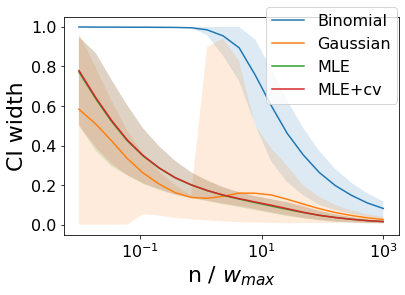

In [9]:
%matplotlib inline

class FlassPlot:
    from matplotlib import scale as mscale
    
    class ExpScale(mscale.ScaleBase):
        from matplotlib import transforms as mtransforms

        """
        Scales data in range -Infinity, 1 using log(1 - x)
        """

        # The scale class must have a member ``name`` that defines the
        # string used to select the scale.  For example,
        # ``gca().set_yscale("mercator")`` would be used to select this
        # scale.
        name = 'exp'

        def __init__(self, axis, **kwargs):
            """
            Any keyword arguments passed to ``set_xscale`` and
            ``set_yscale`` will be passed along to the scale's
            constructor.
            """
            from matplotlib import scale as mscale
            myscale = kwargs.pop("expscale", 1.0)
            mscale.ScaleBase.__init__(self, axis, **kwargs)
            self.myscale = myscale

        def get_transform(self):
            """
            Override this method to return a new instance that does the
            actual transformation of the data.
            """
            return FlassPlot.ExpScale.ExpTransform(self.myscale)

        def set_default_locators_and_formatters(self, axis):
            """
            Override to set up the locators and formatters to use with the
            scale.  This is only required if the scale requires custom
            locators and formatters.  Writing custom locators and
            formatters is rather outside the scope of this example, but
            there are many helpful examples in ``ticker.py``.

            In our case, the Mercator example uses a fixed locator from
            -90 to 90 degrees and a custom formatter class to put convert
            the radians to degrees and put a degree symbol after the
            value::
            """

            return axis

        def limit_range_for_scale(self, vmin, vmax, minpos):
            """
            Override to limit the bounds of the axis to the domain of the
            transform.
            """
            return vmin, vmax

        class ExpTransform(mtransforms.Transform):
            # There are two value members that must be defined.
            # ``input_dims`` and ``output_dims`` specify number of input
            # dimensions and output dimensions to the transformation.
            # These are used by the transformation framework to do some
            # error checking and prevent incompatible transformations from
            # being connected together.  When defining transforms for a
            # scale, which are, by definition, separable and have only one
            # dimension, these members should always be set to 1.
            input_dims = 1
            output_dims = 1
            is_separable = True

            def __init__(self, scale):
                from matplotlib import transforms as mtransforms
                
                mtransforms.Transform.__init__(self)
                self.scale = scale

            def transform_non_affine(self, a):
                """
                This transform takes an Nx1 ``numpy`` array and returns a
                transformed copy.  Since the range of the Mercator scale
                is limited by the user-specified threshold, the input
                array must be masked to contain only valid values.
                ``matplotlib`` will handle masked arrays and remove the
                out-of-range data from the plot.  Importantly, the
                ``transform`` method *must* return an array that is the
                same shape as the input array, since these values need to
                remain synchronized with values in the other dimension.
                """
                import numpy as np
                
                return np.exp(self.scale * a)

            def inverted(self):
                """
                Override this method so matplotlib knows how to get the
                inverse transform for this transform.
                """
                return FlassPlot.ExpScale.InvertedExpTransform(self.scale)

        class InvertedExpTransform(mtransforms.Transform):
            input_dims = 1
            output_dims = 1
            is_separable = True

            def __init__(self, scale):
                from matplotlib import transforms as mtransforms
                
                mtransforms.Transform.__init__(self)
                self.scale = scale

            def transform_non_affine(self, a):
                import numpy as np
                
                return np.log(a / self.scale)

            def inverted(self):
                return FlassPlot.ExpScale.ExpTransform(self.scale)

    @staticmethod
    def yo():
        import matplotlib.pyplot as plt
        plt.figure(figsize=(4,2))
        
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt
        from matplotlib import scale as mscale

        mscale.register_scale(FlassPlot.ExpScale)

        SMALL_SIZE = 16
        MEDIUM_SIZE = 22
        BIGGER_SIZE = 24

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def exppic(x, y, label, expscale, **kwargs):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as ticker
        plt.ylim(0.0, 1.01)
        plt.plot(x, y, label=label, **kwargs)
        plt.gca().set_xscale('log')
        plt.gca().set_yscale('exp', expscale=expscale)
        plt.ylim(0.0, 1.01)
        plt.gca().yaxis.set_major_locator(ticker.FixedLocator([0.38,0.68,0.86,0.95,1]))

        plt.legend()
        
    @staticmethod
    def pic(x, y, label): 
        import matplotlib.pyplot as plt
        plt.semilogx(x, y, label=label)

        #plt.loglog(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def axeslabel(xlabel, ylabel):  
        import matplotlib.pyplot as plt
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        plt.title(title)
        
    @staticmethod
    def legend(**kwargs):
        import matplotlib.pyplot as plt
        plt.legend(**kwargs)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        plt.savefig(filename, bbox_inches='tight')
        
    @staticmethod
    def plt():
        import matplotlib.pyplot as plt
        return plt

import pickle
del allres
allres = pickle.load(open( "epsilongreedy_ciwithcv_allres.p", "rb" ) )

renameit = { "Binomial CI": "Binomial", "Asymptotic Gaussian": "Gaussian", "MLE CI": "MLE", "MLE CI CV": "MLE+cv" }
FlassPlot.forpaper()
for name, res in reversed(allres):
    x = [ x[0] for x in res ]
    y = [ x[1]['width'] for x in res ]
    ylo = [ x[1]['widthlo'] for x in res ]
    yhi = [ x[1]['widthhi'] for x in res ]
    #ylo = [ x[1]['width'] - 1.96 * x[1]['widthstd'] for x in res ]
    #yhi = [ x[1]['width'] + 1.96 * x[1]['widthstd'] for x in res ]
    FlassPlot.plt().semilogx(x, y, label=renameit.get(name, name))
    FlassPlot.plt().fill_between(x, ylo, yhi, alpha=0.15)

FlassPlot.legend(loc="center", bbox_to_anchor=[0.8,0.825])
FlassPlot.axeslabel('n / $w_{max}$', 'CI width')

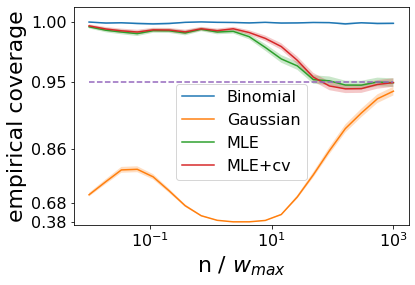

In [10]:
%matplotlib inline

import pickle
del allres
allres = pickle.load(open( "epsilongreedy_ciwithcv_allres.p", "rb" ) )

renameit = { "Binomial CI": "Binomial", "Asymptotic Gaussian": "Gaussian", "MLE CI": "MLE", "MLE CI CV": "MLE+cv" }
FlassPlot.forpaper()
for name, res in reversed(allres):
    x = [ x[0] for x in res ]
    y = [ x[1]['cov'] for x in res ]
    ylo = [ x[1]['cov'] - 1.96 * x[1]['covstd'] for x in res ]
    yhi = [ x[1]['cov'] + 1.96 * x[1]['covstd'] for x in res ]
    FlassPlot.exppic(x, y, label=renameit[name], expscale=7.0)
    FlassPlot.plt().fill_between(x, ylo, yhi, alpha=0.25)
FlassPlot.exppic([ x[0] for x in res ], [ 0.95 for x in res ], label='_nolegend_', expscale=7.0, ls='dashed')
FlassPlot.legend(loc="center", bbox_to_anchor=[0.5,0.425])
FlassPlot.axeslabel('n / $w_{max}$', 'empirical coverage')

In [5]:
from importlib import reload
import environments.ControlledRangeVariance
import MLE.MLE

reload(environments.ControlledRangeVariance)
reload(MLE.MLE)

def megaproduceresults(env, method):
    from math import ceil
    import numpy
    
    wmin, wmax = env.range()

    for ndata in [100000]:
        bounds=[]
        for i in range(1, 101):
            (truevalue, data) = env.sample(ndata)

            try:
                ci = method(data=data, wmin=wmin, wmax=wmax, alpha=0.05)
                assert numpy.isfinite(ci[0]) and numpy.isfinite(ci[1])
#                 assert ci[1] >= ci[0]
#                 assert ci[1] >= truevalue
#                 assert ci[0] <= truevalue
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('ci was {}'.format(ci))
                raise
                                                
            bounds.append(
                ( truevalue,
                  data,
                  [ 
                      ci[0], 'n/a', ci[1]
                  ]
                )  
            )
            
        uppers = [ d[2][2] for d in bounds ]
        lowers = [ d[2][0] for d in bounds ]
        upperbounded = [ 1 if d[0] <= d[2][2] else 0 for d in bounds ]
        lowerbounded = [ 1 if d[2][0] <= d[0] else 0 for d in bounds ]
        covered = [ 1 if u*l > 0 else 0 for (u, l) in zip(upperbounded, lowerbounded) ]
        width = [ d[2][2] - d[2][0] for d in bounds ]    
        yield (ndata,
                { 
                    'coverage': round(sum(covered) / len(covered), 4),
                    'ubcoverage': round(sum(upperbounded) / len(upperbounded), 4),
                    'lbcoverage': round(sum(lowerbounded) / len(lowerbounded), 4),
                    'width': round(sum(width) / len(width), 4),
                    'avub': round(sum(uppers) / len(uppers), 4),
                    'avlb': round(sum(lowers) / len(lowers), 4),
                },
              )

def getenv(expwsq):
    import numpy
    wsupport = [ 0, 2, 1000 ]
    env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=45, wsupport=wsupport, expwsq=expwsq)
    return env, env.getpw(), env.range(), env.expectedwsq()
    
allres = []
for (name, method) in [ ('Binomial', lambda data, wmax, alpha, **kwargs: CITest.ClopperPearson.interval(data, wmax, alpha)),
                        ('MLE', lambda data, **kwargs: MLE.MLE.asymptoticconfidenceinterval(datagen=lambda: data, **kwargs)[0]),
                      ]:
    import numpy
    print('****** {} ******'.format(name))
    res = []
    for expwsq in numpy.linspace(100, 999, 10):
        for zzz in megaproduceresults(getenv(expwsq)[0], method):
            res.append((expwsq, zzz))
            print('{}'.format((expwsq, zzz)), flush=True)
    allres.append((name, res))
import pickle
pickle.dump( allres, open( "epsilongreedy_ci_expwsqsweep.p", "wb" ) )

****** Binomial ******
(100.0, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2635, 'avub': 0.667, 'avlb': 0.4035}))
(199.88888888888889, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2573, 'avub': 0.6378, 'avlb': 0.3805}))
(299.77777777777777, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2667, 'avub': 0.7038, 'avlb': 0.4371}))
(399.66666666666663, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2556, 'avub': 0.6389, 'avlb': 0.3833}))
(499.55555555555554, (100000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.2584, 'avub': 0.6582, 'avlb': 0.3997}))
(599.4444444444445, (100000, {'coverage': 0.98, 'ubcoverage': 0.99, 'lbcoverage': 0.99, 'width': 0.2608, 'avub': 0.649, 'avlb': 0.3881}))
(699.3333333333333, (100000, {'coverage': 0.99, 'ubcoverage': 0.99, 'lbcoverage': 1.0, 'width': 0.2445, 'avub': 0.5947, 'avlb': 0.3502}))
(799.2222222222222, (100000, {

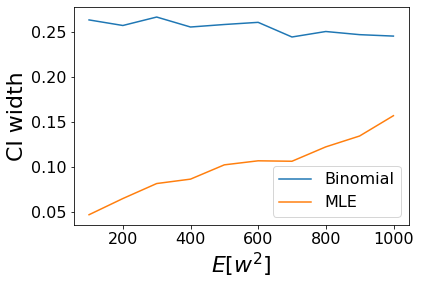

In [6]:
import pickle
allres = pickle.load(open( "epsilongreedy_ci_expwsqsweep.p", "rb" ) )

%matplotlib inline
        
class MegaFlassPlot:
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt

        SMALL_SIZE = 16
        MEDIUM_SIZE = 22
        BIGGER_SIZE = 24

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def pic(x, y, label):
        import matplotlib.pyplot as plt
        
        plt.plot(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def axeslabel(xlabel, ylabel):
        import matplotlib.pyplot as plt
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        
        plt.title(title)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        
        plt.savefig(filename, bbox_inches='tight')       

MegaFlassPlot.forpaper()
for name, res in allres:
    MegaFlassPlot.pic([ x[0] for x in res], [ x[1][1]['width'] for x in res], label=name)
MegaFlassPlot.axeslabel('$E[w^2]$', 'CI width')

In [7]:
from importlib import reload
import environments.Chirpy
import MLE.MLE

reload(environments.Chirpy)
reload(MLE.MLE)

def megaproduceresults(env, method):
    from math import ceil
    import numpy
    
    wmin, wmax = env.range()

    for ndata in [10000]:
        bounds=[]
        for i in range(1, 101):
            (truevalue, data) = env.sample(ndata)

            try:
                ci = method(data=data, wmin=wmin, wmax=wmax, alpha=0.05)
                expwsq = sum(c*w*w for c, w, _ in data) / sum(c for c, _, _ in data)
                assert numpy.isfinite(ci[0]) and numpy.isfinite(ci[1])
#                 assert ci[1] >= ci[0]
#                 assert ci[1] >= truevalue
#                 assert ci[0] <= truevalue
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('ci was {}'.format(ci))
                raise
                                                
            bounds.append(
                ( truevalue,
                  data,
                  [ 
                      ci[0], 'n/a', ci[1]
                  ],
                  expwsq
                )  
            )
            
        uppers = [ d[2][2] for d in bounds ]
        lowers = [ d[2][0] for d in bounds ]
        upperbounded = [ 1 if d[0] <= d[2][2] else 0 for d in bounds ]
        lowerbounded = [ 1 if d[2][0] <= d[0] else 0 for d in bounds ]
        covered = [ 1 if u*l > 0 else 0 for (u, l) in zip(upperbounded, lowerbounded) ]
        width = [ d[2][2] - d[2][0] for d in bounds ]
        expwsqds = [d[3] for d in bounds]
        yield (ndata,
                { 
                    'coverage': round(sum(covered) / len(covered), 4),
                    'ubcoverage': round(sum(upperbounded) / len(upperbounded), 4),
                    'lbcoverage': round(sum(lowerbounded) / len(lowerbounded), 4),
                    'width': round(sum(width) / len(width), 4),
                    'avub': round(sum(uppers) / len(uppers), 4),
                    'avlb': round(sum(lowers) / len(lowers), 4),
                    'avexpwsq': round(sum(expwsqds) / len(expwsqds), 4),
                },
              )

def getenv(numimp):
    import numpy
    wsupport = [ 0, 2, 1000 ]
    env = environments.Chirpy.Chirpy(seed=45, wsupport=wsupport, expwsq=200, nchirp=numimp // 3)
    return env, env.getpw(), env.range(), env.expectedwsq()
    
allres = []
for (name, method) in [ ('Binomial', lambda data, wmax, alpha, **kwargs: CITest.ClopperPearson.interval(data, wmax, alpha)),
                        ('MLE', lambda data, **kwargs: MLE.MLE.asymptoticconfidenceinterval(datagen=lambda: data, **kwargs)[0]),
                      ]:
    import numpy
    print('****** {} ******'.format(name))
    res = []
    for numimp in numpy.ceil(numpy.geomspace(10, 10000, 10)):
        for zzz in megaproduceresults(getenv(numimp)[0], method):
            res.append((numimp, zzz))
            print('{}'.format((numimp, zzz)), flush=True)
    allres.append((name, res))
import pickle
pickle.dump( allres, open( "epsilongreedy_ci_numimpsweep.p", "wb" ) )

****** Binomial ******
(10.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6869, 'avub': 0.88, 'avlb': 0.1932, 'avexpwsq': 188.6021}))
(22.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6623, 'avub': 0.8306, 'avlb': 0.1683, 'avexpwsq': 215.6078}))
(47.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6581, 'avub': 0.8604, 'avlb': 0.2024, 'avexpwsq': 207.6049}))
(100.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6703, 'avub': 0.8826, 'avlb': 0.2123, 'avexpwsq': 193.6031}))
(216.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6949, 'avub': 0.8922, 'avlb': 0.1973, 'avexpwsq': 209.6051}))
(465.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.697, 'avub': 0.9114, 'avlb': 0.2144, 'avexpwsq': 188.6069}))
(1000.0, (10000, {'coverage': 1.0, 'ubcoverage': 1.0, 'lbcoverage': 1.0, 'width': 0.6875, 'avub': 0.8616, 'avlb':

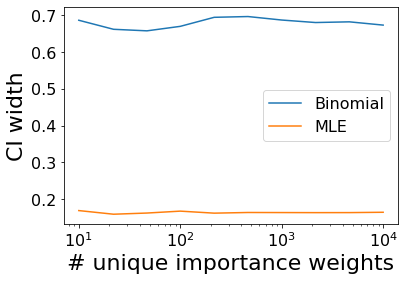

In [8]:
import pickle
allres = pickle.load(open( "epsilongreedy_ci_numimpsweep.p", "rb" ) )

%matplotlib inline
        
class MegaFlassPlot:
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt

        SMALL_SIZE = 16
        MEDIUM_SIZE = 22
        BIGGER_SIZE = 24

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def pic(x, y, label):
        import matplotlib.pyplot as plt
        
        plt.semilogx(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def axeslabel(xlabel, ylabel):
        import matplotlib.pyplot as plt
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        
        plt.title(title)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        
        plt.savefig(filename, bbox_inches='tight')

MegaFlassPlot.forpaper()
for name, res in allres:
    MegaFlassPlot.pic([ x[0] for x in res], [ x[1][1]['width'] for x in res], label=name)
MegaFlassPlot.axeslabel('# unique importance weights', 'CI width')